In [4]:
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [5]:
dl = DataLoader(prices_dir='../../price_data_utils/prices', info_dir='../../price_data_utils/info', 
                analysis_date_str='2019-08-07', cached_dir='../../price_data_utils/cached')
dl.load_data()

Prediction Date: 2019-08-09


In [6]:
data = dl.data
data.head()

,mkt_cap,beta,book_value,sector,eps,month_ago,year_ago,prev_date,analysis_date,trade_date,pred_date,volume
ticker,,,,,,,,,,,,
CSCO,229986631680,0.995519,36804000000,Technology,2.882,56.189999,44.986347,52.599998,52.340000,53.160000,52.430000,24128600.0
SITC,2533060352,0.844472,1499137000,Real Estate,1.043,13.490000,NaN,13.840000,13.780000,14.030000,14.030000,1920086.0
UAL,22748133376,1.223721,10320000000,Industrials,9.838,90.669998,85.220001,85.459999,86.480003,87.629997,86.980003,2380100.0
TROW,26297821184,1.069091,6579100000,Financial Services,7.945,108.959999,112.439903,107.260002,107.040001,110.250000,108.650002,1338400.0
ISRG,61556834304,1.269715,7265300000,Healthcare,10.129,533.159973,525.359985,503.769989,505.359985,519.409973,515.500000,491700.0


In [7]:
hp = HistoricalPrices(prices_dir='../../price_data_utils/prices', 
                      cached_dir='../../price_data_utils/cached',
                      date_str='2019-08-09')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [8]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,2008-01-02,320.000000,296.904999,312.381012,320.000000,379785.0,320.000000,SITC
1,2008-01-03,334.286011,323.809998,323.809998,334.286011,144585.0,334.286011,SITC
2,2008-01-04,331.333008,322.856995,326.761993,323.761993,13020.0,323.761993,SITC
3,2008-01-07,319.286011,312.381012,312.381012,319.286011,2940.0,319.286011,SITC
4,2008-01-08,318.951996,306.761993,312.856995,318.951996,25725.0,318.951996,SITC


In [10]:
def transform_prices(df, end_date_str):
    open_prices_temp = df.pivot(index='Date', columns='ticker', values='Open')
    close_prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')
    
    
    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=3)
    
    open_prices_temp.index = pd.to_datetime(open_prices_temp.index)
    close_prices_temp.index = pd.to_datetime(close_prices_temp.index)
    
    open_prices = open_prices_temp.loc[start_date:end_date]
    close_prices = close_prices_temp.loc[start_date:end_date]
    
    return open_prices.dropna(axis=1), close_prices.dropna(axis=1)
op, cp = transform_prices(prices, '2019-08-07')
returns = cp.pct_change().drop(cp.index[0])
print(op.shape)
print(cp.shape)
returns.head()

(755, 894)
(755, 894)


ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,Y,YUM,Z,ZAYO,ZBH,ZBRA,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-09,0.004658,-0.009569,0.006987,-0.014093,0.004060,0.006331,-0.000564,0.025528,0.001333,0.008754,...,0.001964,-0.000561,-0.035752,0.000704,0.010861,0.083290,-0.026925,0.002088,-0.024823,0.002559
2016-08-10,0.001265,-0.001932,-0.011853,0.000901,-0.007444,-0.004943,-0.008125,0.001054,-0.005989,-0.003207,...,-0.005270,-0.006514,-0.022690,0.004923,-0.031332,0.031837,-0.022690,-0.017014,-0.010909,0.017279
2016-08-11,0.013050,0.008712,0.022821,0.000360,-0.000648,0.007828,0.011945,0.005103,0.005356,-0.022129,...,-0.006395,0.017183,-0.000566,-0.002099,0.004499,0.001697,-0.002548,-0.001060,-0.022059,0.005018
2016-08-12,0.000208,-0.023992,-0.001144,-0.004259,0.002316,0.003585,-0.000450,-0.003223,-0.000222,0.008388,...,-0.001197,-0.000222,-0.002833,-0.001052,-0.001236,0.027568,-0.006245,-0.004951,-0.003759,-0.001728
2016-08-15,0.006232,0.034415,0.027205,0.010602,0.012017,0.002976,0.005399,-0.002425,0.002442,-0.005610,...,-0.001049,-0.000222,0.010511,0.008775,0.004407,0.029826,0.011711,0.017413,0.022641,0.007695


In [11]:
op.head()

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,Y,YUM,Z,ZAYO,ZBH,ZBRA,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-08,47.570000,25.231501,34.220001,170.490005,107.519997,66.379997,89.709999,120.000000,45.060001,52.900002,...,538.109985,63.968369,37.400002,28.320000,131.240005,57.430000,37.240002,29.000000,2.79,51.020000
2016-08-09,47.110001,25.039261,35.209999,168.750000,108.230003,66.339996,88.779999,120.809998,45.070000,52.480000,...,539.650024,63.910854,37.000000,28.400000,131.850006,63.990002,37.000000,28.799999,2.80,50.830002
2016-08-10,47.509998,24.991199,34.590000,166.570007,108.709999,66.699997,88.790001,123.699997,45.080002,53.250000,...,541.299988,64.126526,36.320000,28.510000,129.000000,63.490002,36.139999,28.780001,2.74,50.770000
2016-08-11,47.619999,24.871050,34.250000,167.800003,108.519997,66.860001,87.970001,123.279999,44.849998,52.369999,...,538.590027,63.882099,35.580002,28.620001,129.009995,64.830002,35.490002,28.389999,2.72,51.889999
2016-08-12,47.970001,24.919109,34.740002,166.089996,107.779999,66.860001,89.139999,123.809998,44.820000,51.369999,...,535.419983,64.392525,35.259998,28.410000,129.610001,64.660004,35.150002,28.059999,2.68,51.930000


In [29]:
print(op['CSCO'].head())
print(cp['CSCO'].head())

Date
2016-08-08    31.000000
2016-08-09    31.110001
2016-08-10    31.010000
2016-08-11    30.950001
2016-08-12    30.920000
Name: CSCO, dtype: float64
Date
2016-08-08    28.238792
2016-08-09    28.175053
2016-08-10    28.093094
2016-08-11    28.184156
2016-08-12    28.111303
Name: CSCO, dtype: float64


In [34]:
def create_overnight_factor(op, cp):

    # create factor
    o_r = (op - cp.shift()) / cp.shift()
    return o_r.dropna()

In [35]:
overnight = create_overnight_factor(op, cp)
print(overnight.shape)
overnight.head()

(754, 894)


ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,Y,YUM,Z,ZAYO,ZBH,ZBRA,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-09,0.025591,0.001046,0.056088,0.004564,0.043736,0.131753,0.055736,0.004573,0.062890,0.137856,...,0.016958,0.050246,-0.012807,-0.000704,0.014132,0.103466,-0.003770,0.050504,-0.007092,0.020998
2016-08-10,0.029504,0.008778,0.030293,0.005761,0.044125,0.130735,0.056451,0.003000,0.061711,0.144532,...,0.018068,0.054382,0.004981,0.002461,-0.018450,0.010665,0.000000,0.047588,-0.003636,0.017189
2016-08-11,0.030584,0.005872,0.032403,0.012276,0.050118,0.139079,0.055268,-0.001458,0.062658,0.129239,...,0.018337,0.057250,0.007361,0.001400,0.013377,0.000154,0.004813,0.051278,0.000000,0.021971
2016-08-12,0.024785,-0.000889,0.023809,0.001599,0.043633,0.130232,0.056681,-0.002256,0.056290,0.132743,...,0.018859,0.047695,-0.001133,-0.003857,0.013530,-0.004158,-0.002271,0.040161,0.007519,0.017652
2016-08-15,0.028844,0.011826,0.031473,0.009880,0.044699,0.136469,0.054902,0.000970,0.065482,0.132067,...,0.022329,0.052140,0.000284,-0.000702,0.013845,0.000150,-0.000286,0.053159,0.000000,0.023928


In [41]:
overnight.rolling(5).sum().dropna().head()

ticker,A,AA,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACC,...,Y,YUM,Z,ZAYO,ZBH,ZBRA,ZG,ZION,ZNGA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-15,0.139308,0.026634,0.174066,0.034080,0.226311,0.668268,0.279038,0.004829,0.309031,0.676437,...,0.094551,0.261713,-0.001314,-0.001402,0.036434,0.110277,-0.001513,0.242691,-0.003210,0.101738
2016-08-16,0.138312,0.034287,0.142526,0.000336,0.229093,0.663901,0.273011,-0.004526,0.304795,0.663841,...,0.092317,0.260096,0.005870,-0.001742,0.030841,0.002882,0.005080,0.234644,-0.021948,0.096849
2016-08-17,0.144466,0.033340,0.140564,-0.002594,0.227378,0.664071,0.268985,-0.003933,0.309994,0.653442,...,0.091493,0.256447,0.000004,-0.004907,0.066618,-0.006216,0.009191,0.229522,-0.033237,0.104169
2016-08-18,0.109178,0.036241,0.133668,-0.006669,0.222442,0.652342,0.263403,0.001385,0.309047,0.654077,...,0.090479,0.251688,-0.005305,-0.007354,0.067259,-0.006371,0.004964,0.219987,-0.036996,0.104544
2016-08-19,0.109515,0.030491,0.133689,-0.005868,0.220924,0.650473,0.251925,-0.000637,0.309920,0.649863,...,0.085158,0.253005,-0.011524,-0.008347,0.060545,-0.007897,0.008122,0.221978,-0.044515,0.102799


In [42]:
def create_weekly_overnight_factor(overnight, data):

    # create factor
    fr = overnight.rolling(5).sum().dropna()
    sector_data = data['sector']
    index_ = sector_data.index.intersection(fr.columns)
    sector_data = sector_data.loc[index_]
    df = fr.loc[:, index_].dropna().copy() # to use only the stocks that are in sector_data
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [43]:
factor = create_weekly_overnight_factor(overnight, data)
factor.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-15,1.452752,-1.022453,0.801382,-0.327659,-1.200099,-0.086849,0.785591,1.318530,-0.860597,0.540834,...,0.639527,-0.367136,-0.217123,0.201332,0.931656,-1.594869,-1.527758,-0.998767,0.560573,1.373798
2016-08-16,1.456699,-1.093511,0.805330,-0.343449,-1.283001,-0.059215,0.797434,1.385641,-0.825068,0.560573,...,0.698742,-0.351345,-0.221071,0.217123,0.935604,-1.586973,-1.523810,-0.971133,0.564520,1.290896
2016-08-17,1.448804,-1.089564,0.781644,-0.323711,-1.283001,0.663213,0.777696,1.385641,-0.832964,0.536886,...,0.655317,-0.335554,-0.268443,0.201332,0.951394,-1.586973,-1.523810,-0.986924,0.556625,1.294844
2016-08-18,1.436961,-1.054035,0.789539,-0.351345,-1.259315,0.675056,0.757957,1.377745,-0.844807,0.556625,...,0.643474,-0.343449,-0.292129,0.181594,0.982976,-1.586973,-1.515915,-1.034296,0.576363,1.286949
2016-08-19,1.440909,-1.065878,0.769800,-0.288182,-1.259315,0.659265,0.785591,1.389589,-0.832964,0.560573,...,0.615840,-0.363188,-0.359240,0.197385,1.038244,-1.586973,-1.515915,-1.014558,0.584259,1.283001


In [45]:
f = factor.stack()
print(f.shape)
adj_p = cp.loc[factor.index,:].copy()
print(adj_p.shape)

(657750,)
(750, 894)


In [46]:
factor_data = {}
factor_data['factor'] = al.utils.get_clean_factor_and_forward_returns(f, adj_p, periods=[1])

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [47]:
factor_data['factor'].head()

1D    factor  factor_quantile
date       asset                                     
2016-08-15 CSCO  -0.002244  1.452752                5
           UAL   -0.000417 -1.022453                2
           TROW   0.000000  0.801382                4
           ISRG  -0.010029 -0.327659                3
           NVR   -0.002862 -1.200099                1

In [48]:
factor_return_list = []
for key, val in factor_data.items():
    factor_return = al.performance.factor_returns(val)
    factor_return.columns = [key]
    factor_return_list.append(factor_return)

In [49]:
factor_return_list[0].head()

,factor
date,
2016-08-15,-0.000857
2016-08-16,0.001115
2016-08-17,-0.000818
2016-08-18,-0.000259
2016-08-19,0.002285


factor    0.949961
Name: 2019-08-06 00:00:00, dtype: float64
              factor
date                
2016-08-15  0.999143
2016-08-16  1.000257
2016-08-17  0.999438
2016-08-18  0.999179
2016-08-19  1.001462


/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


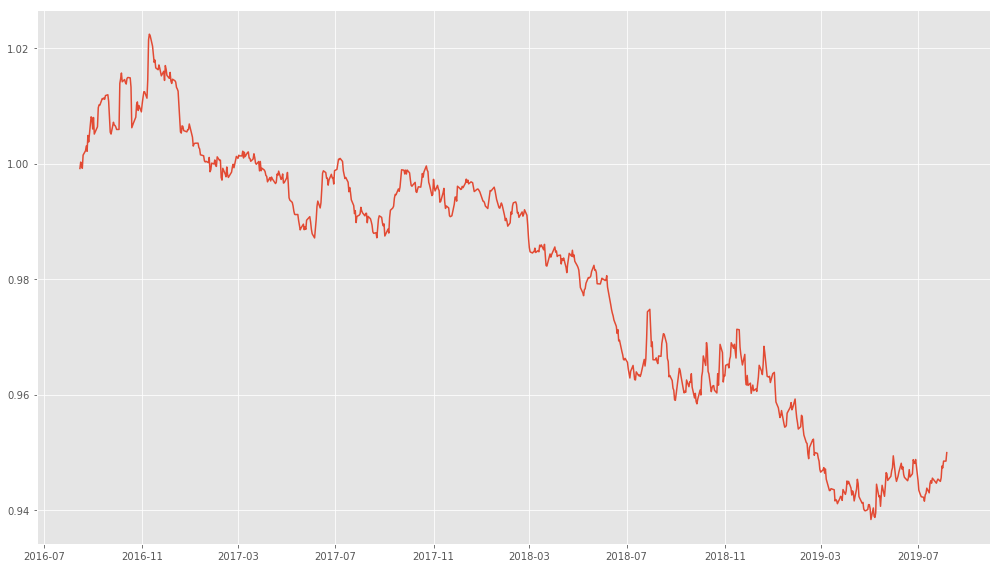

In [50]:
fac_1 = factor_return_list[0]
ret = (fac_1 + 1.0).cumprod() 
print(ret.loc[ret.index[-1],:])
print(ret.head())
plt.plot(ret)
plt.tight_layout()

In [51]:
fra_list = []
for key, val in factor_data.items():
    fra = al.performance.factor_rank_autocorrelation(val).to_frame()
    fra.columns = [key]
    fra_list.append(fra)
    
fra_df = pd.concat(fra_list, axis=1)

In [52]:
fra_df.head()

,factor
date,
2016-08-15,NaN
2016-08-16,0.991248
2016-08-17,0.998280
2016-08-18,0.999151
2016-08-19,0.999122


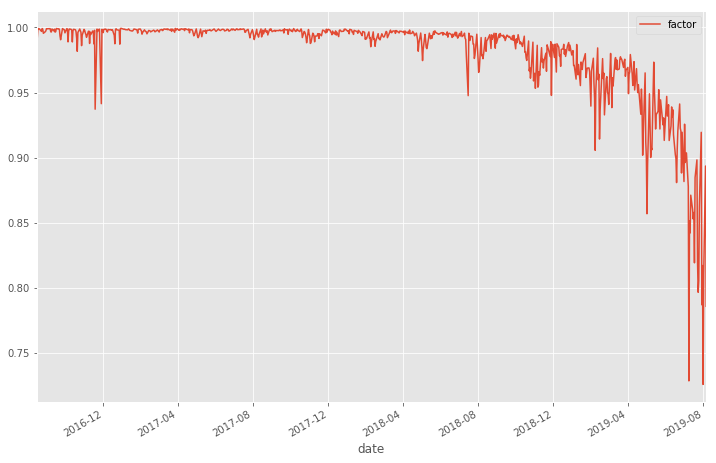

In [53]:
fra_df.plot(figsize=(12,8))

# Quantile Analysis

In [54]:
factor_names = factor_data.keys()
factor_names

dict_keys(['factor'])

In [55]:
ls_qr = []
for i, factor_name in enumerate(factor_names):
    quantile_return, quantile_stderr = al.performance.mean_return_by_quantile(factor_data[factor_name])
    quantile_return.columns = [factor_name]
    ls_qr.append(quantile_return)
df_ls_qr = pd.concat(ls_qr, axis=1)
df_ls_qr

,factor
factor_quantile,
1,-0.000136
2,0.000222
3,0.000134
4,0.000034
5,-0.000251


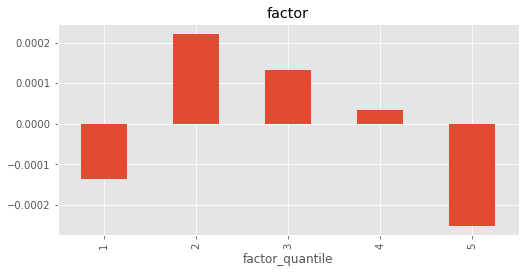

In [56]:
df_ls_qr.plot.bar(subplots=True, sharey=True, layout=(4,2), figsize=(14, 14), legend=False)
plt.tight_layout()

## Convert to basis points

In [57]:
df_ls_qr_bp = 1e4 * df_ls_qr
df_ls_qr_bp

,factor
factor_quantile,
1,-1.361815
2,2.222620
3,1.336873
4,0.336311
5,-2.511753


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11f1f07f0>,
      dtype=object)

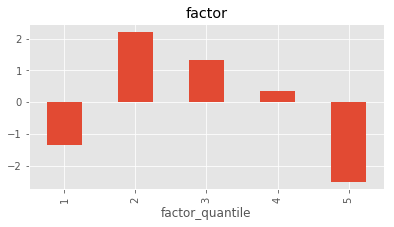

In [58]:
df_ls_qr_bp.plot.bar(subplots=True, sharey=True, layout=(4,2), figsize=(14,14), legend=False)

In [60]:
sfpr = al.performance.factor_returns(factor_data['factor'])
mean = sfpr.mean()
std = sfpr.std()
sharpe = np.sqrt(252) * mean/std
sharpe

1D   -0.762524
dtype: float64

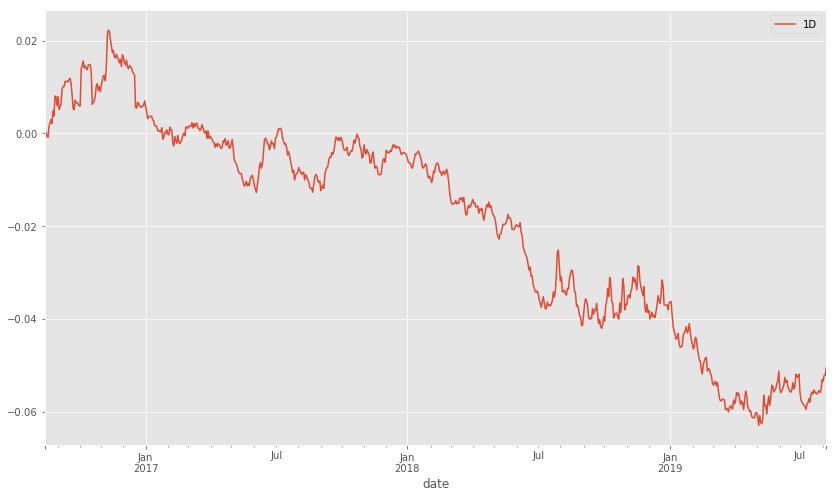

In [61]:
sfpr.cumsum().plot()

In [62]:
autocorr = al.performance.factor_information_coefficient(factor_data['factor'])
autocorr.head()

,1D
date,
2016-08-15,0.097775
2016-08-16,0.097337
2016-08-17,-0.042074
2016-08-18,0.054572
2016-08-19,-0.038541


In [64]:
autocorr.mean()

1D   -0.004681
dtype: float64